<a href="https://colab.research.google.com/github/srabhine/projet_modelisation_image_captioning/blob/main/Modelisation_projet_Sammy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Towards Unsupervised Remote Sensing Image Captioning and Retrieval with Pre-Trained Language Models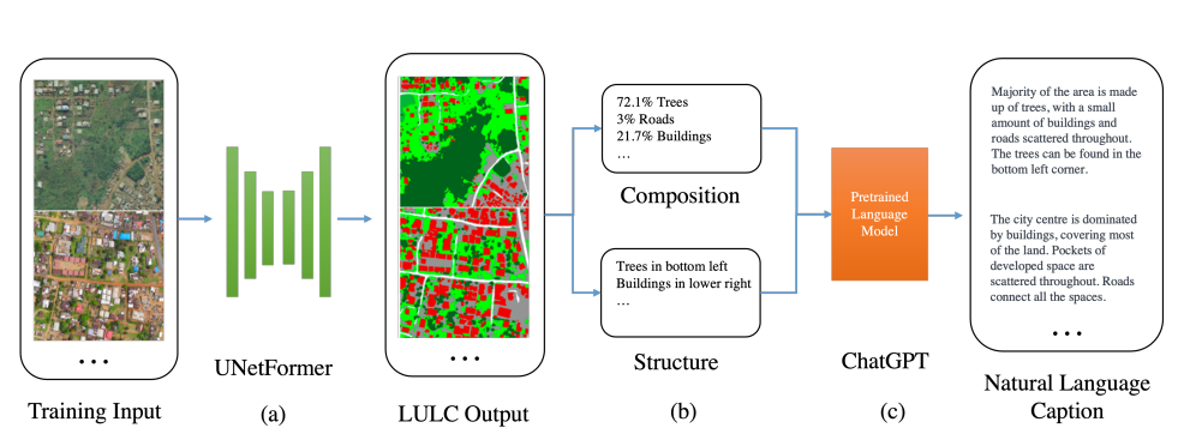**



Original implementation found at https://github.com/bao18/open_earth_map/blob/main/Demo.ipynb

Cross-modal text-image retrieval and captioning systems is an interesting opportunity to combine Geo-spatial information with Natural Language Processing techniques.
Motivated to study unsupervised approaches for RSI captioning to reduce the overhead of manually generating such annotations to train for retrieval systems.
We aim to explore if it is possible for such pre-trained language models to recognize higher-level information such as landscape (e.g., rural, urban, and forest) with controlled generation based on statistical LULC information.


We have 3 main methods that we will use on this notebook:



*   Land Cover Mapping
*   Statistical Image Understanding
*   Natural Language Generation

Cloning a GitHub repository named "open_earth_map". We will need it to have all the data of the Open Earth Map that we will train for the semantic segmentation and after test it

In [ ]:
!git clone https://github.com/bao18/open_earth_map.git

Cloning into 'open_earth_map'...
remote: Enumerating objects: 355, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 355 (delta 25), reused 24 (delta 24), pack-reused 326
Receiving objects: 100% (355/355), 10.19 MiB | 15.10 MiB/s, done.
Resolving deltas: 100% (201/201), done.


In [ ]:
!pip install git+https://github.com/bao18/open_earth_map

  Cloning https://github.com/bao18/open_earth_map to /tmp/pip-req-build-dm8_y_rs
  Running command git clone --filter=blob:none --quiet https://github.com/bao18/open_earth_map /tmp/pip-req-build-dm8_y_rs
  Resolved https://github.com/bao18/open_earth_map to commit f16da336f8abf549e94a206ef67ab869654a557e
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 51.2 MB/s eta 0:00:00
  Created wheel for open-earth-map: filename=open_earth_map-0.1-py3-none-any.whl size=13734 sha256=1b9eaf0e275fce824b7187262dd542f81cb6d063c4bbd8ee453baaae5deab162
  Stored in directory: /tmp/pip-ephem-wheel-cache-kbc38xcx/wheels/75/d1/66/25f8ca0e4061d1b9b2a2e8c48c1607c5612ad98c5ae1707e97
Successfully built open-earth-map


## Imports

In [ ]:
import time
import warnings
import numpy as np
import torch
import rasterio
import cv2
import open_earth_map as oem
import torchvision
from pathlib import Path
import matplotlib.pyplot as plt
import os
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Defines main parameters

In [ ]:
# Path to the OpenEarthMap directory
OEM_DATA_DIR = "/content/drive/My Drive/OpenEarthMap_Mini/"

# Training and validation file list
TRAIN_LIST = os.path.join(OEM_DATA_DIR, "train.txt")
VAL_LIST = os.path.join(OEM_DATA_DIR, "val.txt")

IMG_SIZE = 512
N_CLASSES = 9
LR = 0.0001
BATCH_SIZE = 8
NUM_EPOCHS = 150
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
fns = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
train_fns = [str(f) for f in fns if f.name in np.loadtxt(TRAIN_LIST, dtype=str)]
val_fns = [str(f) for f in fns if f.name in np.loadtxt(VAL_LIST, dtype=str)]

print("Total samples      :", len(fns))
print("Training samples   :", len(train_fns))
print("Validation samples :", len(val_fns))

Total samples      : 1068
Training samples   : 663
Validation samples : 92


## Data Augmentation

In [ ]:
train_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Rotate(),
        oem.transforms.Crop(IMG_SIZE),
    ],
)

val_augm = torchvision.transforms.Compose(
    [
        oem.transforms.Resize(IMG_SIZE),
    ],
)

## Data Loading

In [ ]:
train_data = oem.dataset.OpenEarthMapDataset(
    train_fns,
    n_classes=N_CLASSES,
    augm=train_augm,
)

val_data = oem.dataset.OpenEarthMapDataset(
    val_fns,
    n_classes=N_CLASSES,
    augm=val_augm,
)

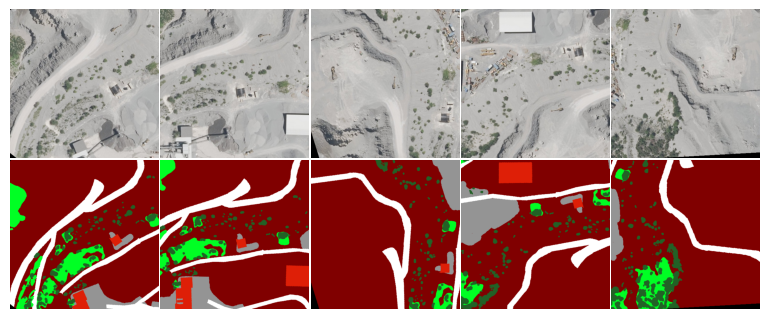

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(5*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

IDX = 10
for i in range(5):
    img, msk, fn = train_data[IDX]

    img = np.moveaxis(img.numpy(), 0, -1)
    msk = oem.utils.make_rgb(np.argmax(msk.numpy(), axis=0))

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(msk)
    axs[1, i].axis("off")

plt.show()

## Land Cover Mapping

As we can see here, we have photos from the training data with there associated masks. The goal is to reproduce it on the test set with our model

In [ ]:
train_data_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=True,
    drop_last=True,
)
val_data_loader = torch.utils.data.DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    num_workers=10,
    shuffle=False,
)

## Network, optimizer and criterion

For the segmentation between the images and their associated mask I used a U-Net architecture that have shown state of the art performances on segmentation tasks.
The network is trained using labelled image pairs
of RSI and LULC images. The predictions are a 2D array
where each cell’s location (row, column) corresponds to
the predicted class of the pixel at the same location.
I used a Dice Loss since it has 2 main advantages:


*   Better at preserving fined-grained details in the segmentation mask
*   Less sensitive to class imabalance



In [ ]:
model_path= "/content/drive/My Drive/OpenEarthMap_Mini/unet_Dice_model.pth"
network = oem.networks.UNet(in_channels=3, n_classes=N_CLASSES)
checkpoint = torch.load(model_path, map_location=DEVICE)
state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint
network.load_state_dict(state_dict)
network.to(DEVICE)
optimizer = torch.optim.Adam(network.parameters(), lr=LR)
criterion = oem.losses.DiceLoss()

## Training

In [ ]:
torch.cuda.empty_cache()

In [ ]:
start = time.time()

max_score = 0
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch: {epoch + 1}")

    train_logs = oem.runners.train_epoch(
        model=network,
        optimizer=optimizer,
        criterion=criterion,
        dataloader=train_data_loader,
        device=DEVICE,
    )

    valid_logs = oem.runners.valid_epoch(
        model=network,
        criterion=criterion,
        dataloader=val_data_loader,
        device=DEVICE,
    )
    epoch_score = valid_logs["Score"]
    if max_score < epoch_score:
        max_score = epoch_score
        oem.utils.save_model(
            model=network,
            epoch=epoch,
            best_score=max_score,
            model_name="unet_ce_model.pth",
            output_dir=OUTPUT_DIR,
        )

print("Elapsed time: {:.3f} min".format((time.time() - start) / 60.0))


Epoch: 1


Valid: 100%|██████████| 12/12 [00:21<00:00,  1.82s/it, Loss=6.51, Score=0.186]


model saved

Epoch: 2


Valid: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, Loss=6.4, Score=0.2]


model saved

Epoch: 3


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.43s/it, Loss=6.4, Score=0.2]


model saved

Epoch: 4


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.43s/it, Loss=6.38, Score=0.202]


model saved

Epoch: 5


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.42s/it, Loss=6.41, Score=0.199]



Epoch: 6


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.43s/it, Loss=6.38, Score=0.202]


model saved

Epoch: 7


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.43s/it, Loss=6.4, Score=0.2]



Epoch: 8


Valid: 100%|██████████| 12/12 [00:16<00:00,  1.41s/it, Loss=6.39, Score=0.201]



Epoch: 9


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.42s/it, Loss=6.33, Score=0.208]


model saved

Epoch: 10


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.43s/it, Loss=6.29, Score=0.214]


model saved

Epoch: 11


Valid: 100%|██████████| 12/12 [00:16<00:00,  1.41s/it, Loss=6.32, Score=0.21]



Epoch: 12


Valid: 100%|██████████| 12/12 [00:16<00:00,  1.37s/it, Loss=6.34, Score=0.208]



Epoch: 13


Valid: 100%|██████████| 12/12 [00:16<00:00,  1.39s/it, Loss=6.31, Score=0.211]



Epoch: 14


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.42s/it, Loss=6.29, Score=0.214]



Epoch: 15


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.42s/it, Loss=6.32, Score=0.21]



Epoch: 16


Valid: 100%|██████████| 12/12 [00:16<00:00,  1.42s/it, Loss=6.41, Score=0.198]



Epoch: 17


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.44s/it, Loss=6.32, Score=0.209]



Epoch: 18


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.42s/it, Loss=6.29, Score=0.213]



Epoch: 19


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.43s/it, Loss=6.29, Score=0.213]



Epoch: 20


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.43s/it, Loss=6.3, Score=0.213]



Epoch: 21


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.45s/it, Loss=6.21, Score=0.223]


model saved

Epoch: 22


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.45s/it, Loss=6.33, Score=0.208]



Epoch: 23


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.42s/it, Loss=6.34, Score=0.208]



Epoch: 24


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.47s/it, Loss=6.26, Score=0.217]



Epoch: 25


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.46s/it, Loss=6.17, Score=0.228]


model saved

Epoch: 26


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.42s/it, Loss=6.23, Score=0.222]



Epoch: 27


Valid: 100%|██████████| 12/12 [00:16<00:00,  1.38s/it, Loss=6.2, Score=0.224]



Epoch: 28


Valid: 100%|██████████| 12/12 [00:16<00:00,  1.37s/it, Loss=6.16, Score=0.229]


model saved

Epoch: 29


Valid: 100%|██████████| 12/12 [00:16<00:00,  1.41s/it, Loss=6.1, Score=0.237]


model saved

Epoch: 30


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.43s/it, Loss=6.13, Score=0.233]



Epoch: 31


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.44s/it, Loss=6.7, Score=0.163]



Epoch: 32


Valid: 100%|██████████| 12/12 [00:18<00:00,  1.53s/it, Loss=6.13, Score=0.234]



Epoch: 33


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.49s/it, Loss=6.13, Score=0.233]



Epoch: 34


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.48s/it, Loss=6.17, Score=0.229]



Epoch: 35


Valid: 100%|██████████| 12/12 [00:18<00:00,  1.57s/it, Loss=6.2, Score=0.225]



Epoch: 36


Valid: 100%|██████████| 12/12 [00:18<00:00,  1.50s/it, Loss=6.16, Score=0.229]



Epoch: 37


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.50s/it, Loss=6.21, Score=0.224]



Epoch: 38


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.46s/it, Loss=6.21, Score=0.224]



Epoch: 39


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.45s/it, Loss=6.12, Score=0.235]



Epoch: 40


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.47s/it, Loss=6.14, Score=0.232]



Epoch: 41


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.45s/it, Loss=6.13, Score=0.234]



Epoch: 42


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.45s/it, Loss=6.15, Score=0.232]



Epoch: 43


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.43s/it, Loss=6.0, Score=0.25]


model saved

Epoch: 44


Valid: 100%|██████████| 12/12 [00:16<00:00,  1.41s/it, Loss=6.14, Score=0.232]



Epoch: 45


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.43s/it, Loss=6.16, Score=0.23]



Epoch: 46


Valid: 100%|██████████| 12/12 [00:16<00:00,  1.37s/it, Loss=6.08, Score=0.239]



Epoch: 47


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.42s/it, Loss=6.01, Score=0.249]



Epoch: 48


Valid: 100%|██████████| 12/12 [00:16<00:00,  1.41s/it, Loss=6.03, Score=0.247]



Epoch: 49


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.42s/it, Loss=6.15, Score=0.231]



Epoch: 50


Valid: 100%|██████████| 12/12 [00:16<00:00,  1.41s/it, Loss=6.05, Score=0.244]



Epoch: 51


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.43s/it, Loss=6.0, Score=0.251]


model saved

Epoch: 52


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.43s/it, Loss=6.05, Score=0.244]



Epoch: 53


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.45s/it, Loss=6.09, Score=0.239]



Epoch: 54


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.46s/it, Loss=6.09, Score=0.239]



Epoch: 55


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.49s/it, Loss=6.09, Score=0.239]



Epoch: 56


Valid: 100%|██████████| 12/12 [00:18<00:00,  1.52s/it, Loss=5.97, Score=0.253]


model saved

Epoch: 57


Valid: 100%|██████████| 12/12 [00:18<00:00,  1.58s/it, Loss=6.07, Score=0.241]



Epoch: 58


Valid: 100%|██████████| 12/12 [00:18<00:00,  1.57s/it, Loss=6.17, Score=0.229]



Epoch: 59


Valid: 100%|██████████| 12/12 [00:19<00:00,  1.60s/it, Loss=6.08, Score=0.24]



Epoch: 60


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.50s/it, Loss=5.99, Score=0.252]



Epoch: 61


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.43s/it, Loss=6.0, Score=0.251]



Epoch: 62


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.43s/it, Loss=6.0, Score=0.25]



Epoch: 63


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.42s/it, Loss=6.12, Score=0.235]



Epoch: 64


Valid: 100%|██████████| 12/12 [00:17<00:00,  1.44s/it, Loss=6.11, Score=0.237]



Epoch: 65


Valid: 100%|██████████| 12/12 [00:16<00:00,  1.40s/it, Loss=6.03, Score=0.246]



Epoch: 66


Train:  94%|█████████▍| 77/82 [02:53<00:08,  1.78s/it, Loss=5.87, Score=0.266]

## Samples of the test set

In [ ]:
TEST_LIST = os.path.join(OEM_DATA_DIR, "test.txt")

img_paths = [f for f in Path(OEM_DATA_DIR).rglob("*.tif") if "/images/" in str(f)]
test_fns = [str(f) for f in img_paths if f.name in np.loadtxt(TEST_LIST, dtype=str)]

print("Total samples   :", len(img_paths))
print("Testing samples :", len(test_fns))

Total samples   : 1068
Testing samples : 313


In [ ]:
test_data = oem.dataset.OpenEarthMapDataset(test_fns, n_classes=N_CLASSES, augm=None, testing=True)

## Predictions

In [ ]:
network = oem.networks.UNetFormer(in_channels=3, n_classes=N_CLASSES)
network = oem.utils.load_checkpoint(network, model_name="/content/drive/My Drive/unet_model_21_01_24.pth")

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Loaded model:/content/drive/My Drive/unet_model_21_01_24.pth (Epoch=132, Score=0.253)


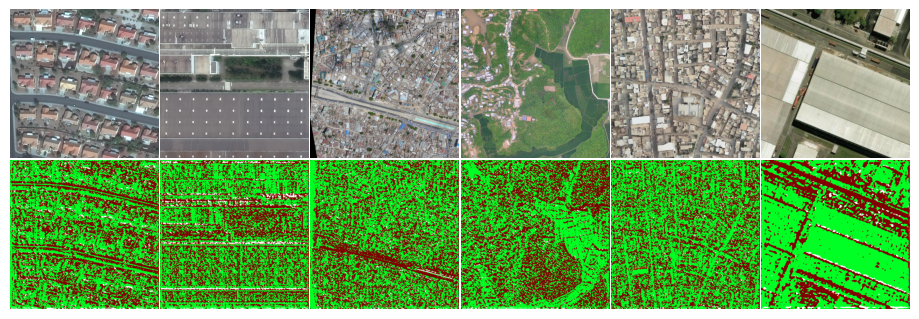

In [ ]:
# visualize predictions
NPLOT = 6
idxs = np.argsort(np.random.rand(len(test_fns)))[:NPLOT]

fig, axs = plt.subplots(2, NPLOT, figsize=(NPLOT*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

network.eval().to(DEVICE)
for i, idx in enumerate(idxs):
    img, *_ = test_data[idx]

    with torch.no_grad():
        prd = network(img.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()

    img = np.moveaxis(img.numpy(), 0, -1)
    prd = oem.utils.make_rgb(np.argmax(prd.numpy(), axis=0))

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(prd)
    axs[1, i].axis("off")
plt.show()

We can notice here that the model performs very badly. We have 5 different images that basically predicts all the same colors which cannot be true since 1 color = 1 classe (white= roads, green= vegetation...)

In [ ]:
def get_counts(found, num_classes: int = 9):
    counts = np.zeros(num_classes)
    for k, v in found:
        counts[k] = v
    return counts

In [2]:
#oem.utils.class_grey_oem

In [ ]:
classes_reversed = dict(reversed(item) for item in oem.utils.class_grey_oem.items())

Here are the 9 classes that will determine the statistical image understanding the so called "land classes"
The goal is to translate the image composition and land cover structure into a template statistical prompt for the next step. The land cover classes are mapped to their text labels pre-defined by the training
dataset in the prompt.

In [ ]:
classes_reversed

{0: 'unknown',
 1: 'Bareland',
 2: 'Grass',
 3: 'Pavement',
 4: 'Road',
 5: 'Tree',
 6: 'Water',
 7: 'Cropland',
 8: 'buildings'}

## Image composition

Suppose class C is one of the classes present in a predicted LULC image 𝐼
, we calculate the percentage of the composition for class C as follows.

𝐶𝑜𝑚𝑝𝑜𝑠𝑡𝑖𝑜𝑛(C | 𝐼) = # pixels predicted as C / Total # of pixels

In [ ]:
def get_description(percentages, grey_codes: dict = classes_reversed):
    description = ""

    for i in range(len(percentages)):
        if (percentages[i] > 1):
            description += "%.1f%% %s, " % (round(percentages[i], 1), grey_codes[i])

    return description

## Land cover structure

To describe the locations of prominent land classes. We use the median location of top 2 classes in the LULC, We locate the centroid of
each class. Unlike calculating mean, median is more robust
to outliers. If the centroid falls into a circle with a radius
of 10% of image size from the center, it is classified with
Center location.
Any centroid outside of this area is classified as either Upper
left, Upper Right, Lower Left, or Lower Right by dividing
the image into four quadrants with the center of the image
as the center of the quadrant.

In [ ]:
# getting the center of the segment
def get_center(prd, mask):
    # Assume binary_mask is a 2D numpy array with dtype bool
    binary_mask = (prd == mask)
    centroid = np.median(np.argwhere(binary_mask),axis=0)
    centroid_x, centroid_y = int(centroid[1]), int(centroid[0])

    return centroid_x, centroid_y

# After trying 4 point method, we find 1 point is better indicator of location
def get_location(x,y, size = 1024, threshold = 0.1):
    center = size / 2
    offset = center * threshold

    # print(center)
    # print(offset)
    # print(x,y)

    # check if in center
    if abs(center - x) <= offset and abs(center - y) <= offset:
        return 'center'

    # print(center)
    # print(x,y)
    # check corners
    # lower left
    if x < center and y > center:
        return 'lower left'
    # lower right
    if x > center and y > center:
        return 'lower right'
    # upper left
    if x < center:
        return 'upper left'
        # upper right
    if x > center:
        return 'upper right'

## Predictions on the test data with the statistical image understanding

30.8% Grass, 3.1% Pavement, 57.1% Tree, 8.6% Cropland, Tree in center. Grass in center. 
1.6% Grass, 26.1% Pavement, 3.2% Road, 3.1% Tree, 29.8% Water, 12.4% Cropland, 23.8% buildings, Water in upper left. Pavement in lower right. 
31.8% Pavement, 2.7% Road, 2.4% Tree, 29.8% Water, 7.4% Cropland, 25.1% buildings, Pavement in upper left. Water in lower right. 
5.5% Pavement, 57.1% Water, 34.0% Cropland, 1.1% buildings, Water in lower right. Cropland in upper right. 
15.0% Grass, 11.4% Pavement, 4.5% Road, 14.0% Tree, 2.3% Water, 47.2% Cropland, 5.8% buildings, Cropland in lower right. Grass in upper left. 
21.7% Pavement, 4.5% Road, 9.8% Water, 1.2% Cropland, 62.4% buildings, buildings in center. Pavement in upper right. 


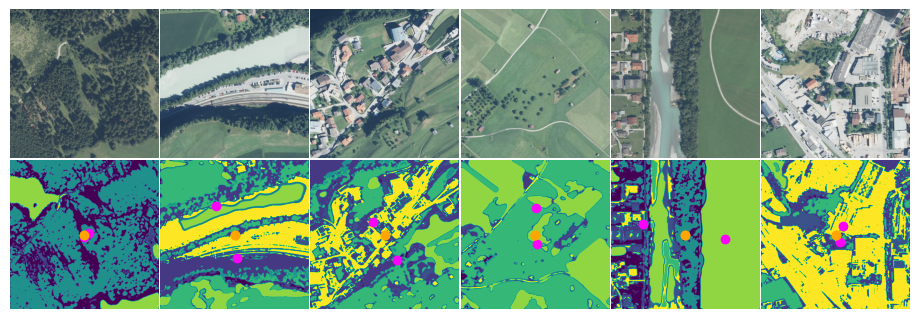

In [ ]:
# visualize predictions
NPLOT = 6
#idxs = np.argsort(np.random.rand(len(test_fns)))[:NPLOT]
idxs = np.array([0, 1, 2, 3, 4, 5])
np.set_printoptions(suppress=True)

fig, axs = plt.subplots(2, NPLOT, figsize=(NPLOT*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

network.eval().to(DEVICE)
for i, idx in enumerate(idxs):
    img, *_ = test_data[idx]

    with torch.no_grad():
        prd = network(img.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()

    img = np.moveaxis(img.numpy(), 0, -1)
    newprd = np.argmax(prd.numpy(), axis=0)
    found_classes, found_counts = np.unique(newprd, return_counts=True)

    count = get_counts(zip(found_classes, found_counts))
    percentages = (count / sum(count)) * 100

    description = get_description(percentages)
    #print(description)

    biggest_classes = (-percentages).argsort()[:2]

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(newprd)
    for biggest_class in biggest_classes:
        center = get_center(newprd, biggest_class)
        #print(biggest_class)
        #print(center)
        location = get_location(center[0], center[1])
        desc = classes_reversed[biggest_class] + ' in ' + location
        description += desc + '. '

        axs[1, i].plot(center[0],center[1], marker="o", markersize=6, color="magenta")
        axs[1, i].plot(1024/2, 1024/2, marker="o", markersize=6, color="orange")
        axs[1, i].axis("off")
    print(description)

After testing it on the test data, let's test it on the RSCID data. We need the RSCID dataset to compare our text generation with a ground truth. The RSCID data has several advantages such has having the most numbers of RSI that are annoted. We use the datasets library which is used with hugging face.

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

rsicd_dataset = load_dataset("arampacha/rsicd", split="train")

In [ ]:
rsicd_captions_all = []
rsicd_images_all = []

In [ ]:
rsicd_images_all

[]

In [ ]:
[500, 1700, 1800, 1900, 2000, 2600, 2900, 3000, 3600, 6600]

[500, 1700, 1800, 1900, 2000, 2600, 2900, 3000, 3600, 6600]

In [ ]:
rsicd_dataset[500]

{'filename': 'rsicd_images/bareland_300.jpg',
 'captions': ['many cars parked on the side of the earth.',
  'the bare earth has grown a small amount of vegetation.',
  'the bare land grew a small amount of vegetation .',
  'A lot of cars parked on the side of the earth.',
  'a lot of cars parked on the side of the land .'],
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>}

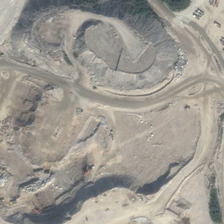

In [ ]:
rsicd_dataset[500]['image']

In [ ]:
rsicd_images_all = []

indices = [500, 1700, 1800, 1900, 2000, 2600, 2900, 3000, 3600, 6600]
for idx in indices:
    rsicd_images_all.append(rsicd_dataset[idx]['image'])


In [ ]:
rsicd_images_all

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>]

As we can see here, these are the ground truth captions that will be compared against the chatGPT generation

In [ ]:
rsicd_captions_all = ['the bare earth has grown a small amount of vegetation.',
 'many buildings and green trees are in a business area .',
 'many commercial tall buildings are in a commercial area .',
 'some buildings and green trees are in a commercial area .',
 'many buildings and many green trees are in a dense residential area .',
 'many pieces of agricultural land are together.',
 'many green trees are in a piece of forest .',
 'a bare land in the middle of the forest.',
 'some buildings and many green trees are located in an average residential area.',
 'a building is surrounded by many green trees .']

In [ ]:
import math
from open_earth_map import transforms
from PIL import Image

def get_rsicd_data(idx, n_classes = 9):
    img = rsicd_images_all[idx]
    msk = Image.fromarray(np.zeros(img.size[:2], dtype="uint8"))
    classes = np.arange(n_classes).tolist()
    to_tensor = transforms.ToTensor(classes=classes)

    h, w = msk.size
    power_h = math.ceil(np.log2(h) / np.log2(2))
    power_w = math.ceil(np.log2(w) / np.log2(2))
    if 2**power_h != h or 2**power_w != w:
        img = img.resize((2**power_w, 2**power_h), resample=Image.BICUBIC)
        msk = msk.resize((2**power_w, 2**power_h), resample=Image.NEAREST)
        data = {"image": img, "mask": msk}

    data = to_tensor(
        {
            "image": np.array(data["image"], dtype="uint8"),
            "mask": np.array(data["mask"], dtype="uint8"),
        }
    )
    return data["image"], data["mask"]

10.1% Pavement, 9.8% Road, 78.6% Cropland, 1.4% buildings, Cropland in upper left. Pavement in lower left. 
12.5% Grass, 59.8% Pavement, 10.2% Road, 8.9% Tree, 8.5% buildings, Pavement in lower right. Grass in upper right. 
86.0% Pavement, 3.3% Road, 10.7% buildings, Pavement in center. buildings in lower left. 
38.9% Grass, 36.4% Pavement, 17.2% Tree, 6.2% buildings, Grass in upper right. Pavement in center. 
34.8% Grass, 35.2% Pavement, 23.9% Tree, 5.6% buildings, Pavement in lower left. Grass in upper right. 
66.1% Grass, 2.0% Pavement, 13.8% Tree, 18.0% Cropland, Grass in lower left. Cropland in upper right. 
1.8% Grass, 91.2% Tree, 6.9% Cropland, Tree in center. Cropland in upper left. 
14.7% Grass, 42.0% Pavement, 5.6% Road, 30.6% Tree, 3.0% Water, 4.1% buildings, Pavement in lower right. Tree in upper left. 
16.1% Grass, 21.0% Pavement, 1.6% Road, 56.8% Tree, 4.3% buildings, Tree in upper right. Pavement in lower left. 
5.4% Grass, 2.1% Pavement, 92.5% Tree, Tree in center. Gras

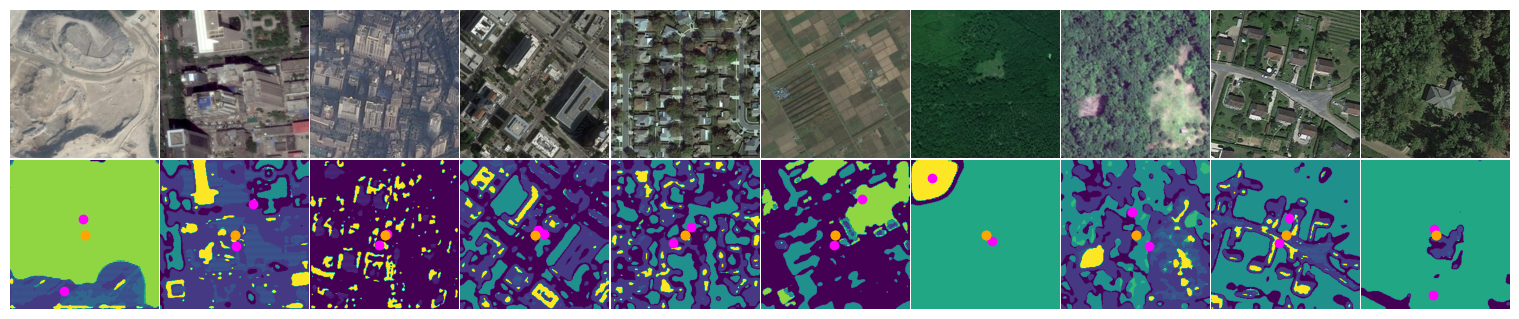

In [ ]:
# visualize predictions
NPLOT = len(rsicd_captions_all)
idxs = range(len(rsicd_captions_all))

np.set_printoptions(suppress=True)

fig, axs = plt.subplots(2, NPLOT, figsize=(NPLOT*1.5, 2*1.5))
fig.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.01, wspace=0.01)

network.eval().to(DEVICE)
for i, idx in enumerate(idxs):
    img, *_ = get_rsicd_data(idx)

    with torch.no_grad():
        prd = network(img.unsqueeze(0).to(DEVICE)).squeeze(0).cpu()

    img = np.moveaxis(img.numpy(), 0, -1)
    newprd = np.argmax(prd.numpy(), axis=0)
    found_classes, found_counts = np.unique(newprd, return_counts=True)

    count = get_counts(zip(found_classes, found_counts))
    percentages = (count / sum(count)) * 100

    description = get_description(percentages)

    biggest_classes = (-percentages).argsort()[:2]

    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].imshow(newprd)
    for biggest_class in biggest_classes:
        center = get_center(newprd, biggest_class)
        # print(biggest_class)
        # print(center)
        location = get_location(center[0], center[1], size=len(newprd))
        desc = classes_reversed[biggest_class] + ' in ' + location
        description += desc + '. '

        axs[1, i].plot(center[0],center[1], marker="o", markersize=6, color="magenta")
        axs[1, i].plot(len(newprd)/2, len(newprd)/2, marker="o", markersize=6, color="orange")
        axs[1, i].axis("off")
    print(description)

## Natural Language Generation

To generate the language I used chatGPT. I added 3 constraints

*   10 words max
*   Write a natural image caption in 1 line without numbers
*   And gived 4 sentences as examples to give the LLM the structure and special words such as "area..."

Here are the 4 examples:

1.   'the bare earth has grown a small amount of vegetation.’
2.   'many buildings and green trees are in a business area .’
1.   'some buildings and many green trees are located in an average residential area.’
2.   'a building is surrounded by many green trees .’



---

I generated the sentences directly on chatGPT which we will call candidate.



---

To evaluate my model I will use the BLEU score.

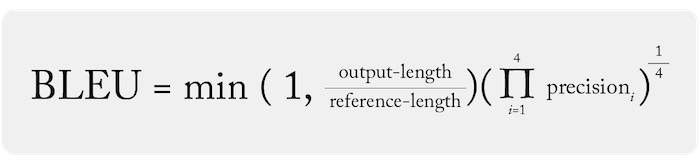


The BLEU (Bilingual Evaluation Understudy) score is a metric evaluation method used primarily to assess the quality of machine-translated texts, such as machine translation systems. It focuses on the accuracy and fluency of the translation by comparing the automatically translated text with one or more reference texts translated by humans.












In [ ]:
# BLEU score

from nltk.translate.bleu_score import sentence_bleu
reference = [
    'the bare earth has grown a small amount of vegetation.'.split(),
 'many buildings and green trees are in a business area .'.split(),
 'many commercial tall buildings are in a commercial area .'.split(),
 'some buildings and green trees are in a commercial area .'.split(),
 'many buildings and many green trees are in a dense residential area .'.split(),
 'many pieces of agricultural land are together.'.split(),
 'many green trees are in a piece of forest .'.split(),
 'a bare land in the middle of the forest.'.split(),
 'some buildings and many green trees are located in an average residential area.'.split(),
 'a building is surrounded by many green trees .'.split()

]

candidate = [
    'Centered pavement with buildings tucked in the lower left.'.split(), # 3rd
    'Grass and trees in the upper right, pavement and buildings center.'.split(), # 4th
    'Pavement in lower left, grass and trees dominate upper right.'.split(), # 5th
    'Dense trees in the center with cropland in the upper left.'.split(), # 7th
    'Pavement in lower right, trees prominent in the upper left.'.split(), # 8th
]

score1 = 0
score2 = 0
score3 = 0
score4 = 0
score = 0

for c in candidate:
    score += sentence_bleu(reference, c)
    score1 += sentence_bleu(reference, c, weights=(1, 0, 0, 0)) #for 1 n-gram
    score2 += sentence_bleu(reference, c, weights=(0, 1, 0, 0)) #for 2 n-gram
    score3 += sentence_bleu(reference, c, weights=(0, 0, 1, 0)) #for 3 n-gram
    score4 += sentence_bleu(reference, c, weights=(0, 0, 0, 1)) #for 4 n-gram

print(score1 / len(candidate))
print(score2 / len(candidate))
print(score3 / len(candidate))
print(score4 / len(candidate))
print(score / len(candidate))

0.35030303030303034
0.08722222222222223
2.2250738585072626e-308
2.2250738585072626e-308
5.302904673807285e-155


## Conclusion

In conclusion as we can see our model performs really badly (score close to 0, the goal is to have them at 1). It can be explained by the poor segmentation model which was performing poorly (IoU of 0.25). In the future directions we can add several adjustements such has improving the u-net model, or considering an another architecture. Also we can try different type of metric to compare the generated text against the reference (ROUGE for example)  